In [2]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

In [3]:
class ResultState(TypedDict):
    value1: int
    value2: int
    result: int

In [4]:
def add(state: ResultState) -> ResultState:
    state['result'] = state['value1'] + state['value2']
    return state

def sub(state: ResultState) -> ResultState:
    state['result'] = state['value1'] - state['value2']
    return state

In [5]:
seq_graph = StateGraph(ResultState)
seq_graph.add_node("add", add)
seq_graph.add_node("sub", sub)
seq_graph.set_entry_point("add")
seq_graph.add_edge("add", "sub")
seq_graph.set_finish_point("sub")
graph = seq_graph.compile()

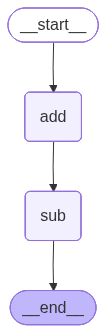

In [6]:
from utils import draw_graph
draw_graph(graph)

In [7]:
state = ResultState(value1 = 10, value2= 3)
result = graph.invoke(state)
print(result)

{'value1': 10, 'value2': 3, 'result': 7}


# To prevent overriting 

##Approach 1 have different values in state
```python
class ResultState(TypedDict):
    value1: int
    value2: int
    add_result: int
    sub_result: int
```

## Approach 2 use list for results
```python
class ResultState(TypedDict):
    value1: int
    value2: int
    result: list[int]
    # result: dict[str, int]
```

In [8]:
## different ways of calling graphs

## use dictionary syntaxes
#state = ResultState(value1 = 10, value2= 3)
result = graph.invoke({"value1": 10, "value2": 3})
print(result)

{'value1': 10, 'value2': 3, 'result': 7}


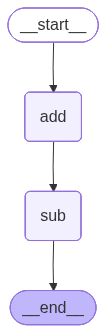

In [10]:
# It is not necessary that every node has to return the complete state
# partial updates are also ok

class ResultState(TypedDict):
    value1: int
    value2: int
    add_result: int
    sub_result: int

    
# nodes with partial updates
def add(state: ResultState):
    return { "add_result": state['value1'] + state['value2']}

def sub(state: ResultState):
    return { "sub_result": state['value1'] - state['value2']}

seq_graph = StateGraph(ResultState)
seq_graph.add_node("add", add)
seq_graph.add_node("sub", sub)
seq_graph.set_entry_point("add")
seq_graph.add_edge("add", "sub")
seq_graph.set_finish_point("sub")
graph = seq_graph.compile()

draw_graph(graph)

In [11]:
result = graph.invoke({"value1": 10, "value2": 3})

In [12]:
result

{'value1': 10, 'value2': 3, 'add_result': 13, 'sub_result': 7}

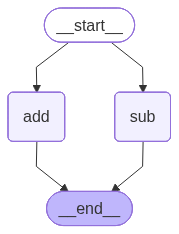

In [13]:
class ResultState(TypedDict):
    value1: int
    value2: int
    add_result: int
    sub_result: int

    
# nodes with partial updates
def add(state: ResultState):
    return { "add_result": state['value1'] + state['value2']}

def sub(state: ResultState):
    return { "sub_result": state['value1'] - state['value2']}

seq_graph = StateGraph(ResultState)
seq_graph.add_node("add", add)
seq_graph.add_node("sub", sub)
seq_graph.add_edge(START, "add")
seq_graph.add_edge("add", END)
seq_graph.add_edge(START, "sub")
seq_graph.add_edge("sub", END)
graph = seq_graph.compile()

draw_graph(graph)

In [14]:
result = graph.invoke({"value1": 10, "value2": 3})

In [15]:
result

{'value1': 10, 'value2': 3, 'add_result': 13, 'sub_result': 7}